### New frequency datasets

Imports

In [32]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse

Set save to True if you want to save plots

In [33]:
save = False

Only for python script: uncomment if running on cluster

In [34]:
# These are both placeholders
num_epochs = 10
model_name = None

In [35]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [37]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Base dataset class

In [38]:
class BaseFourierDataset(Dataset):
    def __init__(self, num_samples, num_points, max_freq):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_freq = max_freq
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives = self.generate_data()

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + n_terms] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Can exclude the first element with the large derivative using [1:]
        # return torch.FloatTensor(self.functions[idx][1:]), torch.FloatTensor(self.first_derivatives[idx][1:])
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx])

    def generate_data(self):
        raise NotImplementedError("Subclasses must implement generate_data method")

In [39]:
class LowFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=5):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

class HighFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, min_freq=15, max_freq=20):
        self.min_freq = min_freq
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            high_freq_coeffs = torch.complex(torch.randn(self.max_freq-self.min_freq+1), 
                                            torch.randn(self.max_freq-self.min_freq+1))
            c[self.max_freq+self.min_freq:] = high_freq_coeffs
            c[:self.max_freq-self.min_freq+1] = torch.conj(high_freq_coeffs.flip(0))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

            functions.append(y.detach().numpy())
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)


In [40]:
class GeneralFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=random.randrange(20)):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

In [41]:
num_samples = 500
num_points = 1000

general_freq_dataset = GeneralFrequencyFourierDataset(num_samples, num_points)
low_freq_dataset = LowFrequencyFourierDataset(num_samples, num_points, max_freq=5)
high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points, min_freq=20, max_freq=30)

# Create DataLoaders
batch_size = 32
general_dataloader = DataLoader(general_freq_dataset, batch_size=batch_size, shuffle=True)
low_freq_dataloader = DataLoader(low_freq_dataset, batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(high_freq_dataset, batch_size=batch_size, shuffle=True)

# Save datasets
torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

General frequency dataset

In [42]:
dataset_g = torch.load('datasets/general_freq_dataset.pt')
total_size = len(dataset_g)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_g, test_dataset_g = random_split(dataset_g, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

Low frequency dataset

In [43]:
dataset_l = torch.load('datasets/low_freq_dataset.pt')
total_size = len(dataset_l)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_l, test_dataset_l = random_split(dataset_l, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

High frequency dataset

In [44]:
dataset_h = torch.load('datasets/high_freq_dataset.pt')
total_size = len(dataset_h)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_h, test_dataset_h = random_split(dataset_h, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)

## Plot a function

Low freq function

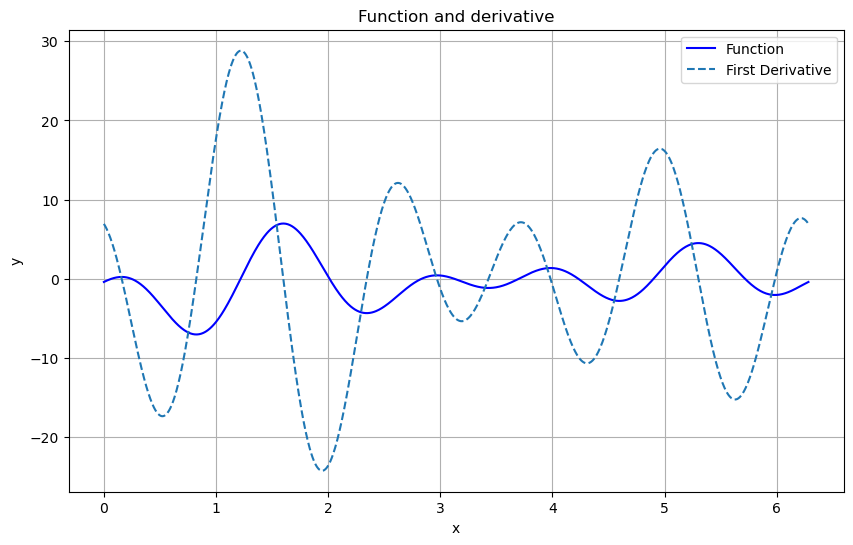

In [45]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    
    plt.title('Function and derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset_l, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

General freq function

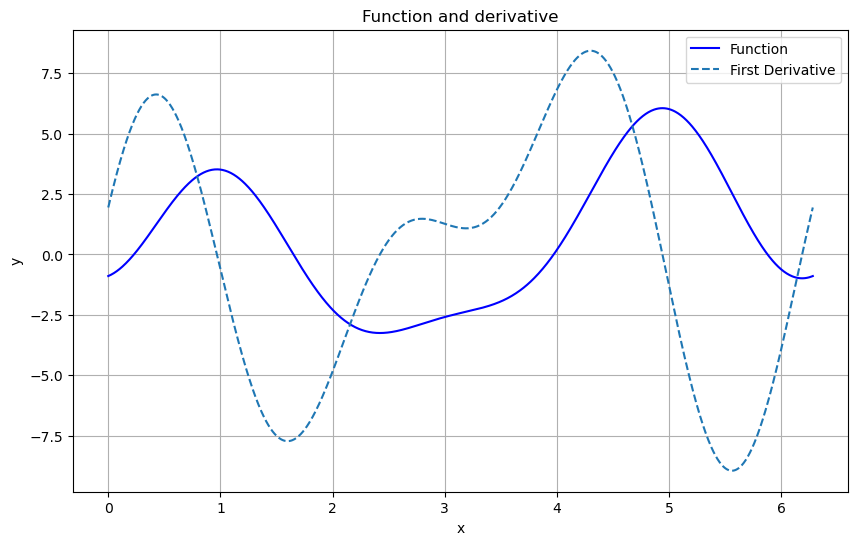

In [46]:
train_dataloader_viz = get_random_function(dataset=train_dataset_g, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

High freq function

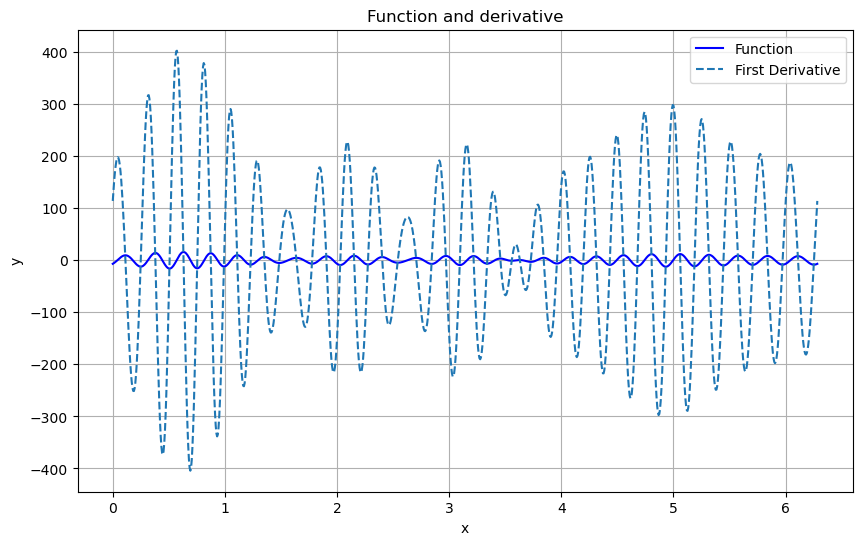

In [47]:
train_dataloader_viz = get_random_function(dataset=train_dataset_h, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [48]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [49]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

To use the previously trained model, uncomment below

In [50]:
# f0.load_state_dict(torch.load('models/f0_E1000_standardized.pth'))

<All keys matched successfully>

## Model training

In [51]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    lr_factor=1, order=None):
    train_losses = []
    test_losses = []

    lr = 1e-3 / lr_factor

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, _ in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, _ in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order}st derivative")
    return train_losses, test_losses

In [52]:
# train_losses, test_losses = model_training(f0, train_dataloader_g, test_dataloader_g,\
#     num_epochs, order='first')
# torch.save(f0.state_dict(), f'models/{model_name}_E{num_epochs}.pth')

## Miscellaneous plotting functions

In [53]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [54]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

## Plot results

In [55]:
plot_losses(train_losses=train_losses, test_losses=test_losses,\
    save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_loss', save=save)

Low frequency output

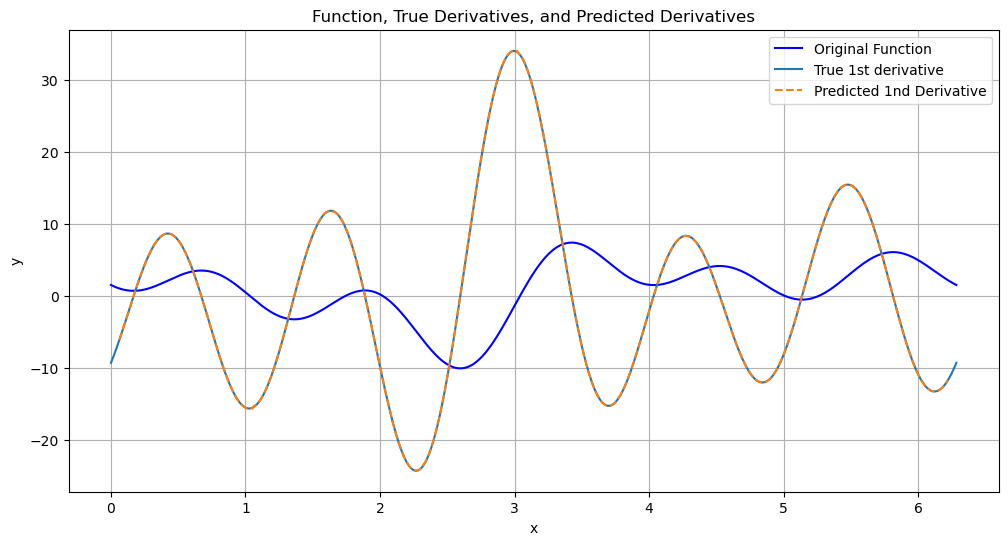

In [56]:
plot_output(f0, dataset=train_dataset_l, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

General frequency output

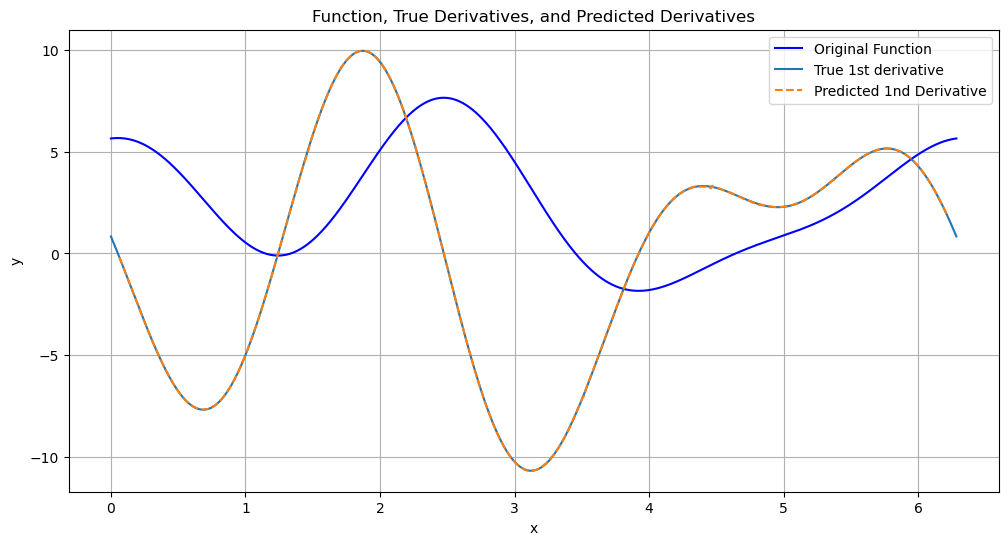

In [57]:
plot_output(f0, dataset=train_dataset_g, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

High frequency output

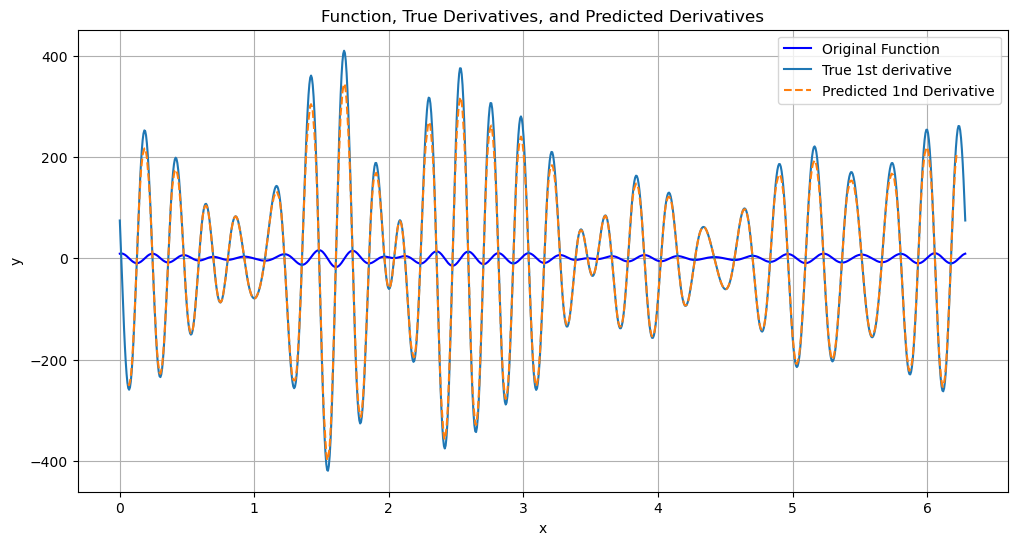

In [58]:
plot_output(f0, dataset=train_dataset_h, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_hf_output', save=save)

## Metrics (MSE and NMSE)

In [59]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

Loss over low frequency functions

In [96]:
print(f"MSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[0]}")
print(f"NMSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[1]}\n")

print(f"MSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[0]}")
print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[1]}")


MSE over low freq train functions: 20.611391067504883
NMSE over low freq train functions: 0.18379004299640656

MSE over low freq test functions: 26.366296768188477
NMSE over low freq test functions: 0.2249179184436798


Loss over general frequency functions

In [69]:
print(f"MSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[0]}")
print(f"NMSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[1]}\n")

print(f"MSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[0]}")
print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[1]}\n")

MSE over general freq train functions: 13.544432640075684
NMSE over general freq train functions: 0.49349671602249146

MSE over general freq test functions: 11.33000373840332
NMSE over general freq test functions: 0.4172048270702362



Loss over high frequency functions

In [77]:
print(f"MSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[0]}")
print(f"NMSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[1]}\n")

print(f"MSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[0]}")
print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[1]}\n")

MSE over high freq train functions: 336.6244812011719
NMSE over high freq train functions: 0.012042686343193054

MSE over high freq test functions: 313.06781005859375
NMSE over high freq test functions: 0.011590874753892422

